# Exploring the Natality Dataset 

**Learning Objectives**

- Explore a BigQuery dataset inside Jupyter notebook
- Read data from BigQuery into Pandas dataframe
- Examine the distribution of average baby weight across various features

## Introduction

In this notebook we'll read data from BigQuery into our notebook to begin some preliminary data exploration of the natality dataset. To beign we'll set environment variables related to our GCP project. 

In [1]:
PROJECT = "qwiklabs-gcp-636667ae83e902b6"  # Replace with your PROJECT
BUCKET =  "qwiklabs-gcp-636667ae83e902b6_al"  # Replace with your BUCKET
REGION = "us-east1"            # Choose an available region for AI Platform  
TFVERSION = "1.13"                # TF version for AI Platform

In [2]:
import numpy as np
import os
import pandas as pd
import pandas_profiling

import tensorflow as tf

os.environ["BUCKET"] = BUCKET
os.environ["PROJECT"] = PROJECT
os.environ["REGION"] = REGION
os.environ["TFVERSION"] = TFVERSION

In [3]:
%%bash
if ! gsutil ls | grep -q gs://${BUCKET}/; then
    gsutil mb -l ${REGION} gs://${BUCKET}
fi

<h2> Explore data </h2>

The data is natality data (record of births in the US). My goal is to predict the baby's weight given a number of factors about the pregnancy and the baby's mother.  Later, we will want to split the data into training and eval datasets. The hash of the year-month will be used for that -- this way, twins born on the same day won't end up in different cuts of the data.

### Full schema: https://bigquery.cloud.google.com/table/bigquery-public-data:samples.natality?pli=1

Other fields that may be useful: 
* mother_race
* cigarette_use
* ever_born

In [4]:
# Create SQL query using natality data after the year 2000
query_string = """
SELECT
    weight_pounds,
    is_male,
    mother_age,
    plurality,
    gestation_weeks,
    ABS(FARM_FINGERPRINT(CONCAT(CAST(YEAR AS STRING), CAST(month AS STRING)))) AS hashmonth
FROM
    publicdata.samples.natality
WHERE
    year > 2000
"""

In [5]:
# Call BigQuery and examine in dataframe
from google.cloud import bigquery
bq = bigquery.Client(project = PROJECT)

df = bq.query(query_string + "LIMIT 100").to_dataframe()
df.head()

,weight_pounds,is_male,mother_age,plurality,gestation_weeks,hashmonth
0,7.109908,False,25,1,38.0,1088037545023002395
1,7.588311,False,19,1,40.0,2126480030009879160
2,4.812691,True,35,1,33.0,3408502330831153141
3,7.251004,True,30,2,38.0,6691862025345277042
4,6.206013,False,21,1,36.0,6392072535155213407


Let's write a query to find see how the number of babies and their average weight is distributed across a given field. This is important to ensure that we have enough examples of each data value, and to verify our hunch that the parameter has predictive value.

#### **Exercise 1**

Consider the field `is_male`. Write a query that will return the unique values for that field (i.e. `False` or `True`) as well as the count of the number of babies for each value and the average weight for each value. 

For example, your query should return the following result:

  is_male | num_babies  | avg_wt  
---------|---------------|-----------
 False  | 16245054  | 7.104715  
 True  | 17026860  | 7.349797 
 
 **Hint**: Look at the usage of operations like COUNT(), AVG() and GROUP BY in SQL.

In [8]:
query = """
SELECT
    is_male, COUNT(*) as num_babies, AVG(weight_pounds) as avg_wt
FROM
    publicdata.samples.natality
WHERE
    year > 2000
GROUP BY is_male    
"""

df = bq.query(query).to_dataframe()

In [9]:
df

,is_male,num_babies,avg_wt
0,True,17026860,7.349797
1,False,16245054,7.104715


#### **Exercise 2**

Now write a function that will generalize your query above. That is, write a function that will take a column name from the natality dataset and return a dataframe containing the unique values for that field as well as the count of the number babies for each value and the average weight for each value.

In [18]:
def get_distinct_values(column_name):
    sql_query = """
    SELECT %s, COUNT(*) as num_babies, AVG(weight_pounds) as avg_wt
    FROM publicdata.samples.natality
    WHERE year > 2000
    GROUP BY %s
    """ % (column_name, column_name)
    return bq.query(sql_query).to_dataframe()

#### **Exercise 3**

Use the `get_distinct_values` function you created above to examine the distributions for the fields `is_male`, `mothers_age`, `plurality` and `gestation_weeks`. After creating the dataframe, plot your results using `df.plot`. Have a look at [the documentation for `df.plot` here](https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.DataFrame.plot.html). 

In [23]:
%pylab inline

Populating the interactive namespace from numpy and matplotlib


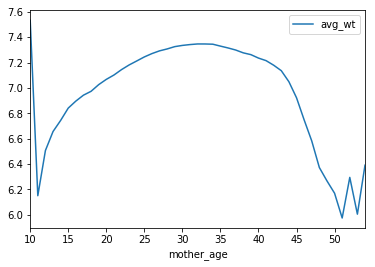

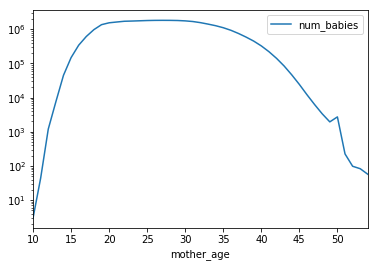

In [24]:
# Use a line plots to see mother_age with avg_wt linear and num_babies logarithmic
df = get_distinct_values('mother_age')

df = df.sort_values("mother_age")
df.plot('mother_age', 'avg_wt', kind='line')
df.plot('mother_age', 'num_babies', kind='line', logy=True)

In [25]:
df['mother_age'].describe()

count    45.000000
mean     32.000000
std      13.133926
min      10.000000
25%      21.000000
50%      32.000000
75%      43.000000
max      54.000000
Name: mother_age, dtype: float64

In [26]:
def get_and_plot_summary(column_name, kind='bar'):
    df = get_distinct_values(column_name)

    df = df.sort_values(column_name)
    df.plot(column_name, 'avg_wt', kind=kind)
    df.plot(column_name, 'num_babies', kind=kind, logy=True)
    
    plt.show()
    return df

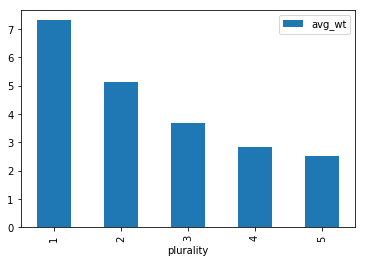

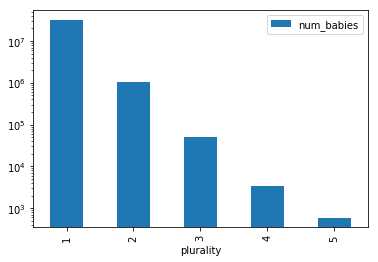

In [27]:
df = get_and_plot_summary('plurality')

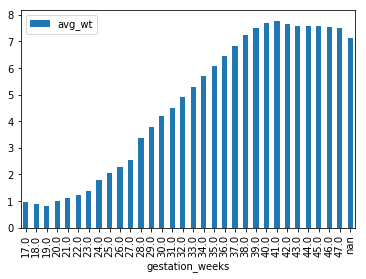

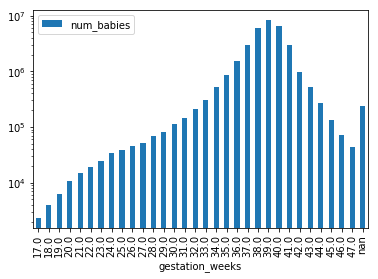

In [56]:
df = get_and_plot_summary('gestation_weeks')

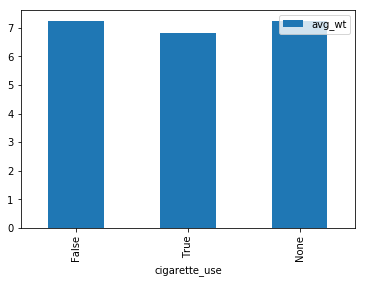

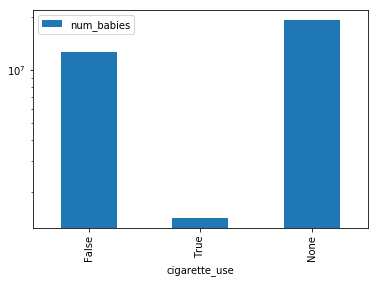

In [58]:
df = get_and_plot_summary('cigarette_use')

Get a sample of data and explore for cross-correlations and other potentially useful factors

In [47]:
sample_query = """
SELECT
    weight_pounds,
    is_male,
    mother_age,
    mother_race,
    mother_residence_state,
    cigarette_use,
    ever_born,
    plurality,
    gestation_weeks
FROM
    publicdata.samples.natality
WHERE
    year > 2000
    AND RAND() < .01
"""

In [48]:
sample_df = bq.query(sample_query).to_dataframe()

In [49]:
len(sample_df)

332798

In [59]:
sample_df.head()

,weight_pounds,is_male,mother_age,mother_race,mother_residence_state,cigarette_use,ever_born,plurality,gestation_weeks
0,7.374463,False,14,2.0,RI,None,1.0,1,40.0
1,5.401325,True,43,1.0,NJ,None,2.0,2,36.0
2,7.914595,True,43,4.0,CA,None,2.0,1,38.0
3,6.686620,False,42,9.0,MO,None,3.0,1,36.0
4,6.000983,False,14,1.0,OK,None,1.0,1,39.0


In [60]:
sample_df['plurality'].corr(sample_df['gestation_weeks'])

-0.25716654110177856

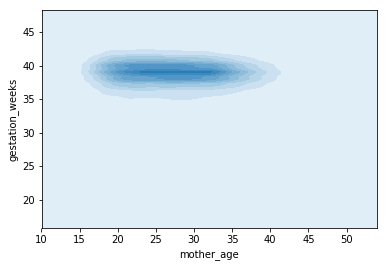

In [66]:
import seaborn as sns
sample_df.dropna(inplace=True)
sns.kdeplot(sample_df['mother_age'], sample_df['gestation_weeks'], shade=True)

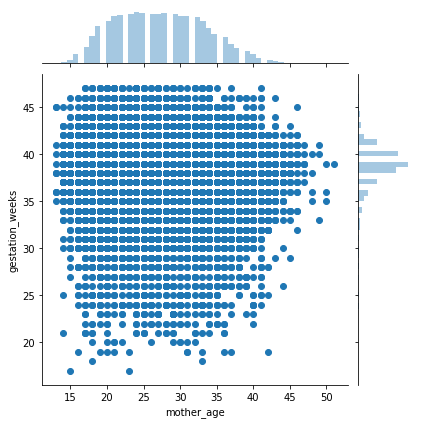

In [68]:
sns.jointplot(sample_df['mother_age'], sample_df['gestation_weeks'])

In [71]:
sample_query = """
SELECT
*
FROM
    publicdata.samples.natality
WHERE
    year > 2000
    AND RAND() < .005
"""

In [72]:
full_sample = bq.query(sample_query).to_dataframe()

In [ ]:
full_sample['weight_pounds'].corr(full_sample[''])

In [73]:
pandas_profiling.ProfileReport(full_sample)

Number of variables,31
Number of observations,165691
Total Missing (%),28.4%
Total size in memory,37.0 MiB
Average record size in memory,234.0 B
Numeric,17
Categorical,6
Boolean,4
Date,0
Text (Unique),0
Rejected,4


Lots of fields have missing data that is intended to be understood as 'False' or zero.

Other fields that have at least a weak univariate correlation with the target are:
* mother_race
* mother_married - may be a proxy for age though
* father_race
* cigarettes_per_day

In [77]:
age_married_q = """
SELECT
    AVG(weight_pounds) as avg_weight,
    COUNT(*) as num_babies,
    mother_age,
    mother_married
FROM
    publicdata.samples.natality
WHERE
    year > 2000
GROUP BY mother_age, mother_married
"""

In [78]:
age_married_df = bq.query(age_married_q).to_dataframe()

In [86]:
married = age_married_df[age_married_df['mother_married']]
single = age_married_df[~age_married_df['mother_married']]
married.sort_values('mother_age', inplace=True)
single.sort_values('mother_age', inplace=True)

/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  This is separate from the ipykernel package so we can avoid doing imports until
/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  after removing the cwd from sys.path.


In [87]:
married.head()

,avg_weight,num_babies,mother_age,mother_married
74,8.031440,2,10,True
9,6.916452,16,12,True
42,6.751079,85,13,True
85,6.835695,1148,14,True
21,6.995517,6294,15,True


In [93]:
single.head()

,avg_weight,num_babies,mother_age,mother_married
10,6.536706,1,10,False
88,6.149945,44,11,False
40,6.500750,1180,12,False
59,6.654992,7467,13,False
54,6.741273,43720,14,False


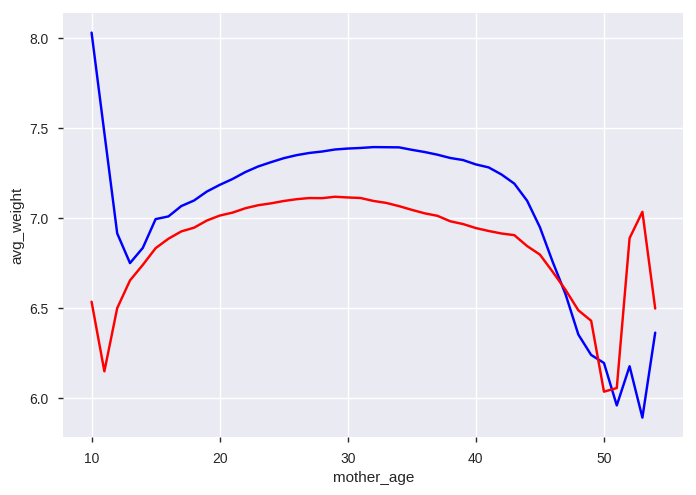

In [97]:
sns.lineplot(married['mother_age'], married['avg_weight'], color='blue')
sns.lineplot(single['mother_age'], single['avg_weight'], color='red')
plt.show()

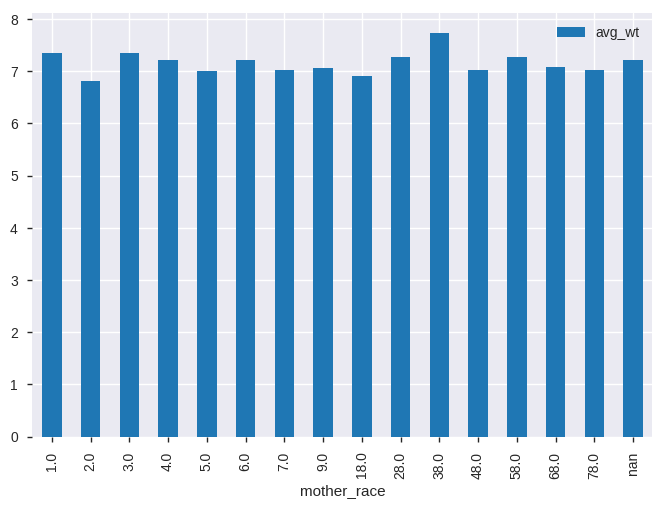

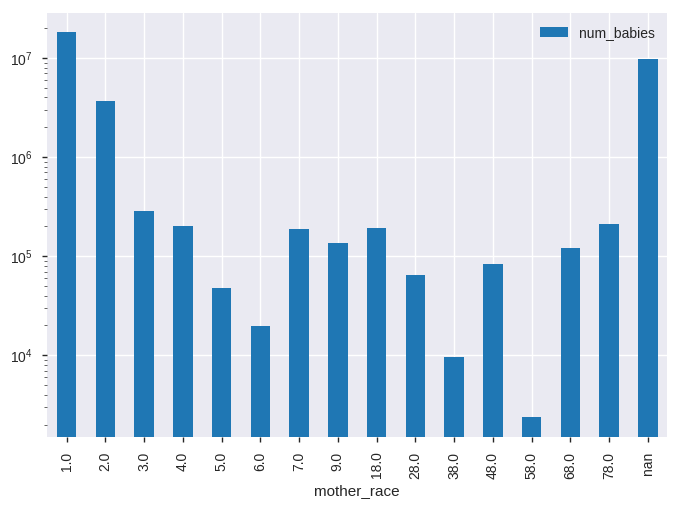

In [98]:
df = get_and_plot_summary('mother_race')

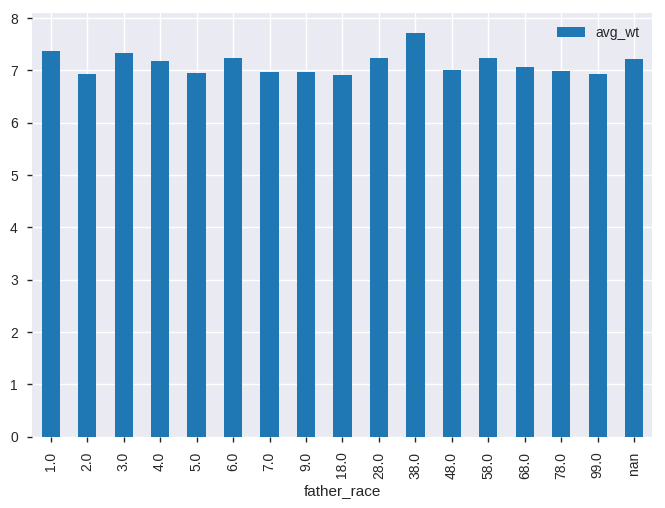

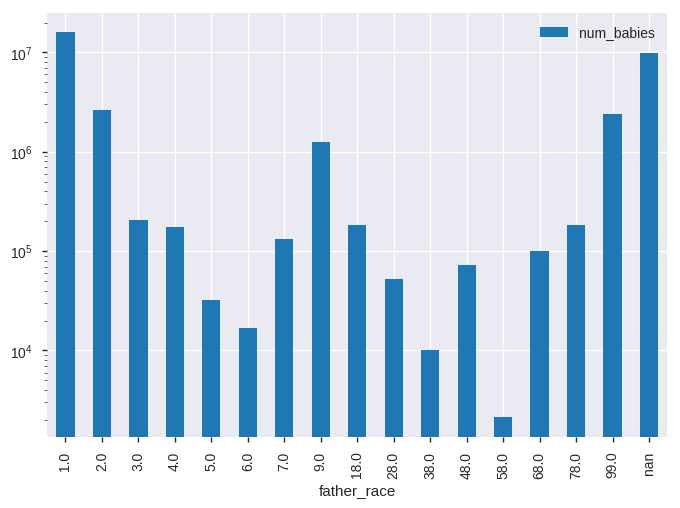

In [100]:
df = get_and_plot_summary('father_race')

## Conclusion 

All these factors seem to play a part in the baby's weight. Male babies are heavier on average than female babies. Teenaged and older moms tend to have lower-weight babies. Twins, triplets, etc. are lower weight than single births. Preemies weigh in lower as do babies born to single moms. In addition, it is important to check whether you have enough data (number of babies) for each input value. Otherwise, the model prediction against input values that doesn't have enough data may not be reliable.
<p>
In the next notebook, we will develop a machine learning model to combine all of these factors to come up with a prediction of a baby's weight.

Copyright 2017-2018 Google Inc. Licensed under the Apache License, Version 2.0 (the "License"); you may not use this file except in compliance with the License. You may obtain a copy of the License at http://www.apache.org/licenses/LICENSE-2.0 Unless required by applicable law or agreed to in writing, software distributed under the License is distributed on an "AS IS" BASIS, WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied. See the License for the specific language governing permissions and limitations under the License